In [38]:
import random 
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt


In [39]:
# Default for numpy: edgeitems = 3, line_width = 80
np.set_printoptions(edgeitems = 14, linewidth = 300)

In [40]:
#without post infeccion inmunity
ALFA = 20 #time to start rolling heal chance
BETA = 0.05 #chance to heal on each roll
AGENTS = 1000
STATE_LEN = 200 
N_ITERATIONS = 350
ELEMENTS = STATE_LEN * STATE_LEN

#add post infection inmunity
inmunity = False
inmunity_dic = {}

AGENTS_A = int(AGENTS * 0.7)
AGENTS_B = int(AGENTS * 0.25)
AGENTS_C = int(AGENTS * 0.05)
AGENTS_INF = int(AGENTS * 0.02)

INFECTED = "_X"
AGENT_A = "A"
AGENT_B = "B"
AGENT_C = "C"
AGENT_KINDS = [AGENT_A, AGENT_B, AGENT_C]
EMPTY = "."
ZERO_TO_STATE_LEN = range(STATE_LEN)

INFECT_NEAR_P = 0.7
INFECT_FAR_P = 0.5

DIRECTIONS = [(0, 1), (0, -1),
              (1, 0), (-1, 0)]

In [41]:
to_infect = np.random.choice( range(AGENTS), AGENTS_INF, replace=False )
infected_pos = []
healthy_pos = []
infection_instance = {}
heal_instance = {}
infection_instanceA = {}
heal_instanceA = {}
infection_instanceB = {}
heal_instanceB = {}
infection_instanceC = {}
heal_instanceC = {}

In [42]:
def setAgents(agents_len, agent, asigned):
    for i in range(agents_len):
        while True:
            x = np.random.choice(ZERO_TO_STATE_LEN, 1)[0]
            y = np.random.choice(ZERO_TO_STATE_LEN, 1)[0]
            
            if ( state[x][y] == EMPTY ):
                break

        state[x][y] = str(asigned) + "_" + agent
        
        if (asigned in to_infect):
            #state[x][y] += INFECTED
            state[x][y] += "_0"
            infected_pos.append( (asigned, x, y) )
        
        else:
            healthy_pos.append( (asigned, x, y) )
            
        asigned += 1
    
    return asigned

In [43]:
state = [] 

# State initialization
for i in ZERO_TO_STATE_LEN:
    state.append([])
    for j in ZERO_TO_STATE_LEN:
        state[i].append(EMPTY)

asigned = 0
asigned = setAgents(AGENTS_A, AGENT_A, asigned)
asigned = setAgents(AGENTS_B, AGENT_B, asigned)
asigned = setAgents(AGENTS_C, AGENT_C, asigned)

# print( np.matrix(state) ) 

In [44]:
print( str( len( infected_pos ) ) + " " + str( len( healthy_pos ) ) )

20 980


In [45]:
def isInfected(string):
  if len(string.split("_")) == 3:
    return True
  else:
    return False

In [46]:
def isPossibleMovement(state, x, y):
    if x<0 or y<0:
      return False
    try:
        state[x][y]
        return True
    except IndexError:
        return False

In [47]:
def _infect(state, next_state, elements, x, y, prob):
    for x, y in elements:
        if ( not isPossibleMovement(state, x, y) ) or (state[x][y] ==  EMPTY) or (isInfected(state[x][y])):
            continue
        id = next_state[x][y].split("_")[0]
        if inmunity == True and id in inmunity_dic and inmunity_dic[id] == True:
          continue

        if (random.random() < prob):
            next_state[x][y] += "_0"

In [48]:
#sospecho, sin fundamento mas mis sospechas, que python ta optimizando el for de _infect concurrentemente y terminan infectados multiples veces osea _0_0_0...
def rectify_states(state, next_state, elements, x, y):
    for x, y in elements:
        if ( not isPossibleMovement(state, x, y) ) or (state[x][y] ==  EMPTY) or (isInfected(state[x][y])):
            continue
        if len(next_state[x][y].split("_"))>3:
          split = next_state[x][y].split("_")
          next_state[x][y] = split[0] + "_" + split[1] + "_" + split[2]

In [49]:
def infect(state, next_state, x, y):
    near = [
        # dist 1
        (x, y + 1), (x + 1, y + 1), (x + 1, y), (x + 1, y - 1), 
        (x, y - 1), (x - 1, y - 1), (x - 1, y), (x - 1, y + 1), 
    
        # dist = 2
        (x, y + 2), (x + 2, y), (x, y - 2), (x - 2, y), 
        (x + 1, y + 1), (x + 1, y - 1), (x - 1, y - 1), (x - 1, y + 1),
    
        # dist = 3
        (x, y + 3), (x + 3, y), (x, y - 3), (x - 3, y),
        (x + 1, y + 2), (x + 2, y + 1), (x + 2, y - 1), (x + 1, y - 2),
        (x - 1, y - 2), (x - 2, y - 1), (x - 2, y + 1), (x - 1, y + 2),
    ]
    
    _infect(state, next_state, near, x, y, INFECT_NEAR_P)
        
    far = [
        # dist 4
        (x, y + 4), (x + 4, y), (x, y - 4), (x - 4, y),
        (x + 1, y + 3), (x + 1, y - 3), (x - 1, y - 3), (x - 1, y + 3),
        (x + 2, y + 2), (x + 2, y - 2), (x - 2, y - 2), (x - 2, y + 2),
        (x + 3, y + 1), (x + 3, y - 1), (x - 3, y - 1), (x - 3, y + 1),
        
        # dist 5
        (x, y + 5), (x + 5, y), (x, y - 5), (x - 5, y),
        (x + 1, y + 4), (x + 1, y - 4), (x - 1, y - 4), (x - 1, y + 4),
        (x + 2, y + 3), (x + 2, y - 3), (x - 2, y - 3), (x - 2, y + 3),
        (x + 3, y + 2), (x + 3, y - 2), (x - 3, y - 2), (x - 3, y + 2),
        (x + 4, y + 1), (x + 4, y - 1), (x - 4, y - 1), (x - 3, y + 1),
        
        # dist 6
        (x, y + 6), (x + 6, y), (x, y - 6), (x - 6, y),
        (x + 1, y + 5), (x + 1, y - 5), (x - 1, y - 5), (x - 1, y + 5),
        (x + 2, y + 4), (x + 2, y - 4), (x - 2, y - 4), (x - 2, y + 4),
        (x + 3, y + 3), (x + 3, y - 3), (x - 3, y - 3), (x - 3, y + 3),
        (x + 4, y + 2), (x + 4, y - 2), (x - 4, y - 2), (x - 4, y + 2),
        (x + 5, y + 1), (x + 5, y - 1), (x - 5, y - 1), (x - 5, y + 1),
    ]
        
    _infect(state, next_state, far, x, y, INFECT_FAR_P)
    
    rectify_states(state, next_state, near, x, y)
    rectify_states(state, next_state, far, x, y)

In [50]:
def notPossibleMovement(state, x, y):
    for dx, dy in DIRECTIONS:
        if not isPossibleMovement(state, x + dx, y + dy):
            continue
            
        if state[x + dx][y + dy] == EMPTY:
            return False
    
    return True

In [51]:
def recover(state, next_state, x, y):
  time_since_infected = state[x][y].split("_")[2]
  if int(time_since_infected) >= ALFA:
    #roll the dice
    if (random.random() < BETA):
        split = state[x][y].split("_")
        healed_agent = split[0]+"_"+split[1]
        next_state[x][y] = healed_agent
        if inmunity == True:
          id = split[0]
          inmunity_dic[ id ] = True
  else:
    new_time_since_infected = int(time_since_infected)+1
    split = state[x][y].split("_")
    still_ill_agent = split[0]+"_"+split[1]+"_"+str(new_time_since_infected)
    next_state[x][y] = still_ill_agent 

In [52]:

infected_pos_plot = []
healthy_pos_plot = []

infected_pos_plot.append( infected_pos )
healthy_pos_plot.append( healthy_pos ) 

In [53]:
def get_type_dic(type,agent_id):
  if type == "inf":
    if agent_id < AGENTS_A:
      return infection_instanceA
    if (AGENTS_A <= agent_id) and agent_id < (AGENTS - AGENTS_C):
      return infection_instanceB
    if agent_id >= (AGENTS - AGENTS_C):
      return infection_instanceC
  else:
    if agent_id < AGENTS_A:
      return heal_instanceA
    if (AGENTS_A <= agent_id) and (agent_id < (AGENTS - AGENTS_C)):
      return heal_instanceB
    if agent_id >= (AGENTS - AGENTS_C):
      return heal_instanceC


In [54]:
def apply_counter_dic(dic,iter):
    if iter in dic:
      dic[iter] += 1
    else:
      dic[iter] = 1

In [55]:
def simulatePandemic(iterations, state):
    prev_move_list = {}
    infected = []
    healthy = []
    for a in range(iterations):
        next_state = np.array( state ).tolist()        
#recover loop
        for i in ZERO_TO_STATE_LEN:
            for j in ZERO_TO_STATE_LEN:
                if state[i][j] == EMPTY:
                    continue
                if isInfected(state[i][j]):
                  recover(state, next_state, i, j)


        state = np.array( next_state ).tolist()  

#infect loop
        for i in ZERO_TO_STATE_LEN:
            for j in ZERO_TO_STATE_LEN:
                if state[i][j] == EMPTY:
                    continue
                if isInfected(state[i][j]):
                  infect(state, next_state, i, j)

        state = np.array( next_state ).tolist()       

        


#moveloop
        for i in ZERO_TO_STATE_LEN:
            for j in ZERO_TO_STATE_LEN:
                if state[i][j] == EMPTY:
                    continue

                to_move = False
                
                if AGENT_A in state[i][j]:
                    to_move = True
                
                elif (AGENT_B in state[i][j]) and (a % 2 == 0):
                    to_move = True
                
                elif AGENT_C in state[i][j] and (a % 4 == 0):
                    to_move = True
                    
                if notPossibleMovement(next_state, i, j) or (not to_move):
                    continue 
                
                agent_id = state[i][j].split("_")[0]
                dx = 0
                dy = 0
                
                while next_state[i + dx][j + dy] != EMPTY:
                    chance_to_insist_direction = 0.2

                    # If there is a previous move
                    if agent_id in prev_move_list:
                      #if agent inist direction
                      if random.random() < chance_to_insist_direction:
                          dx,dy = prev_move_list[agent_id]

                      #if agent does not keep direction
                      else:
                        dir_i = np.random.choice( range( len(DIRECTIONS) ), 1 )[0]
                        dx, dy = DIRECTIONS[dir_i]
                    else:
                      dir_i = np.random.choice( range( len(DIRECTIONS) ), 1 )[0]
                      dx, dy = DIRECTIONS[dir_i]
                    
                    #if movement is not possible look for anotherone, there is a possible movement garatized
                    if not isPossibleMovement(next_state, i + dx, j + dy):
                        dx = 0
                        dy = 0
                        continue
                #whatever move i do, store it as new old move
                prev_move_list[agent_id] = (dx,dy)
                        
                next_state[i][j] = EMPTY
                next_state[i + dx][j + dy] = state[i][j]
           
        prev_infected = infected
        prev_healthy = healthy
        infected = []
        healthy = []

#recaploop
        for i in ZERO_TO_STATE_LEN:
            for j in ZERO_TO_STATE_LEN:
                if next_state[i][j] == EMPTY:
                    continue

                agent_id = next_state[i][j].split("_")[0]
                    
                if isInfected(next_state[i][j]):
                    infected.append( (agent_id, i, j) )
                    
                    was_healthy = False
                    for value in prev_healthy:
                      if agent_id == value[0]:
                          was_healthy = True
                          break
                    if was_healthy == True:
                      apply_counter_dic(infection_instance,a)
                      type_dic = get_type_dic("inf",int(agent_id))
                      apply_counter_dic(type_dic,a)
                      
                else:
                    healthy.append( (agent_id, i, j) )

                    was_infected = False
                    for value in prev_infected:
                      if agent_id == value[0]:
                          was_infected = True
                          break
                    if was_infected == True:
                      apply_counter_dic(heal_instance,a)
                      type_dic = get_type_dic("heal",int(agent_id))
                      apply_counter_dic(type_dic,a)

        infected_pos_plot.append(infected)
        healthy_pos_plot.append(healthy) 
        state = np.array( next_state ).tolist()       
        
        if len(infected) == AGENTS or len(infected) == 0:
            return a + 1
            
    return N_ITERATIONS

In [56]:
def generateDataframe():
  df = pd.DataFrame(healthy_pos_plot[0])
  df['TimeFrame'] = 0
  df['Infected'] = 0

  for i in range(1, N_ITER_AUX):
    temp_df = pd.DataFrame(healthy_pos_plot[i])
    temp_df['TimeFrame']=i
    temp_df['Infected']=0
    df = df.append(temp_df, ignore_index=True)

  for i in range(0, N_ITER_AUX):
    temp_df = pd.DataFrame(infected_pos_plot[i])
    temp_df['TimeFrame']=i
    temp_df['Infected']=1
    df = df.append(temp_df, ignore_index=True)

  df = df.rename( columns={0:'id', 1:'x', 2:'y'} )
  df['id'] = df['id'].astype(int)
  return df

In [57]:
def animation(df):
  fig = px.scatter(df, x="x", y="y", animation_frame="TimeFrame", color="Infected", animation_group="id", hover_name="id",
            log_x=False, size_max=5, range_x=[0,200], range_y=[0,200],width = 700, height= 700, 
            color_continuous_scale=[(0.00, "green"),(0.5, "green"),(0.5, "red"),(1.0, "red")])
  
  fig.update_layout(coloraxis_colorbar=dict(
      title="Estado",
      tickvals=[0.25,0.75],
      ticktext=["Sano","Infectado"],
      lenmode="pixels", len=100,
  ))

  fig.show()

In [58]:
def plot1(df):
  infectados_por_instante = df.groupby("TimeFrame").sum()["Infected"]
  y = infectados_por_instante
  x = infectados_por_instante.index

  # Size and aspect ratio
  grafico, ax = plt.subplots(figsize = (13, 8));

  # Axis
  plt.xlabel("Instancia", fontsize = 16)
  plt.ylabel("Cantidad de infectados", fontsize = 16)

  # Título
  plt.title("Infectados a medida que transcurre el tiempo", fontsize = 20)

  # Axis limits
  plt.xlim([0, N_ITER_AUX]);
  plt.ylim([0, AGENTS]);

  plt.fill_between(x, y)

In [59]:
def plot2(df):
  
  infectados_por_instante = df.groupby("TimeFrame").sum()["Infected"]
  sanos_por_instante = (infectados_por_instante - 1000)*-1

  y = sanos_por_instante
  x = sanos_por_instante.index

  # Size and aspect ratio
  grafico, ax = plt.subplots(figsize = (13, 8));

  # Axis
  plt.xlabel("Instancia", fontsize = 16)
  plt.ylabel("Cantidad de Sanos", fontsize = 16)

  # Título
  plt.title("Sanos a medida que transcurre el tiempo", fontsize = 20)

  # Axis limits
  plt.xlim([0, N_ITER_AUX]);
  plt.ylim([0, AGENTS]);

  plt.fill_between(x, y)

In [60]:
def plot3(dic,titulo):
  

  # Size and aspect ratio
  grafico, ax = plt.subplots(figsize = (13, 8));

  # Axis
  plt.xlabel("Instancia", fontsize = 16)
  #plt.ylabel("Cantidad de infectados", fontsize = 16)

  # Título
  plt.title(titulo, fontsize = 20)

  # Axis limits
  plt.xlim([0, N_ITER_AUX]);
  plt.ylim([0, AGENTS / 20 ]);

  plt.bar( dic.keys(), dic.values() )

In [61]:
N_ITER_AUX = simulatePandemic(N_ITERATIONS, state) + 1

In [62]:
#for i in range(N_ITER_AUX):
#  print( str(i) + ": " + str( len( infected_pos_plot[i] ) ) + " + " + str( len( healthy_pos_plot[i] ) ) + " = " + str( len( healthy_pos_plot[i] ) + len( infected_pos_plot[i] ) )  )

In [63]:
df = generateDataframe()

In [64]:
animation(df)

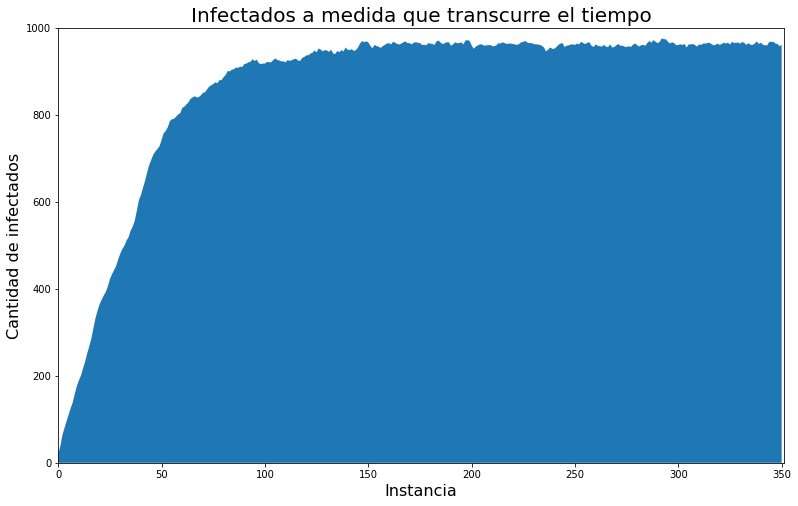

In [65]:
plot1(df)

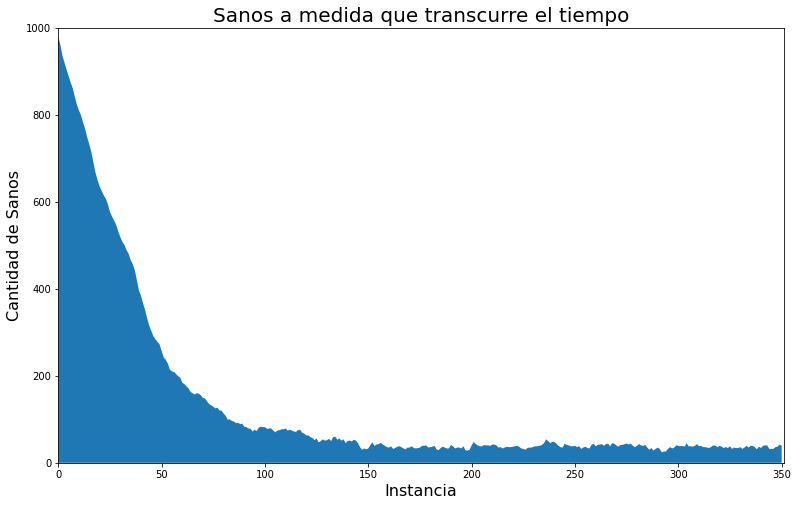

In [66]:
plot2(df)

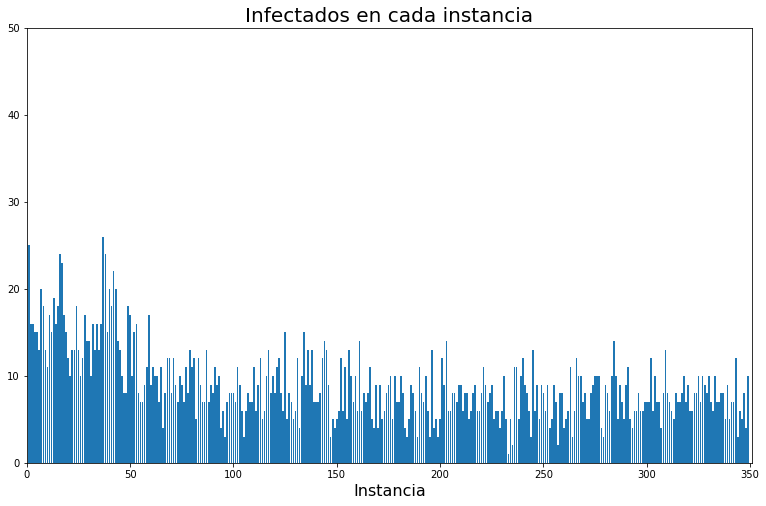

In [67]:
plot3(infection_instance,"Infectados en cada instancia")

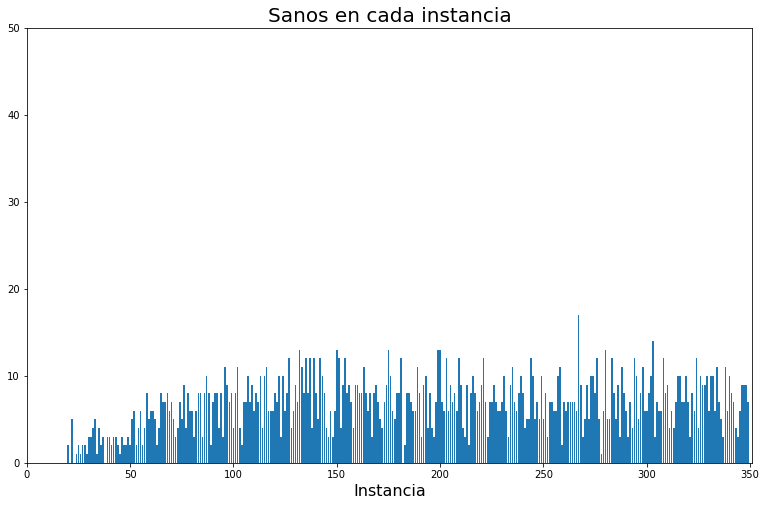

In [68]:
plot3(heal_instance,"Sanos en cada instancia")

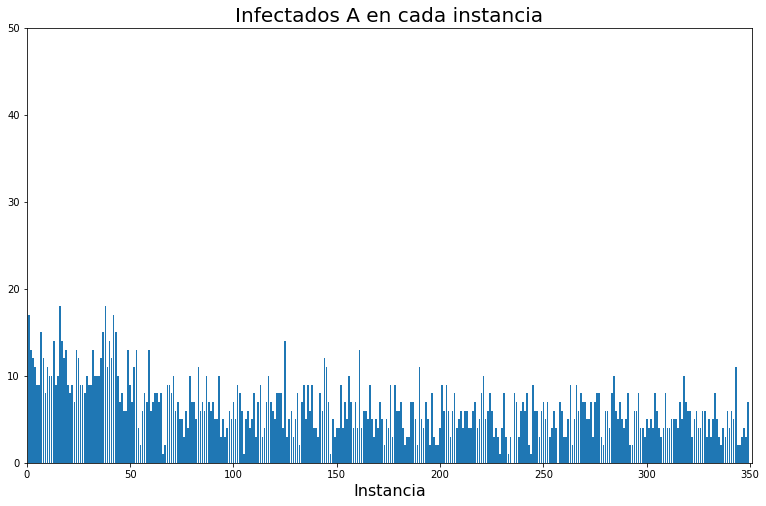

In [69]:
plot3(infection_instanceA,"Infectados A en cada instancia")

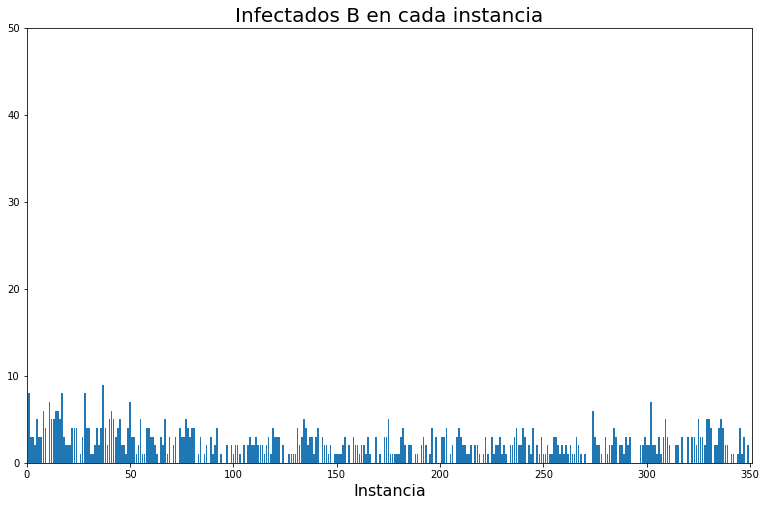

In [70]:
plot3(infection_instanceB,"Infectados B en cada instancia")

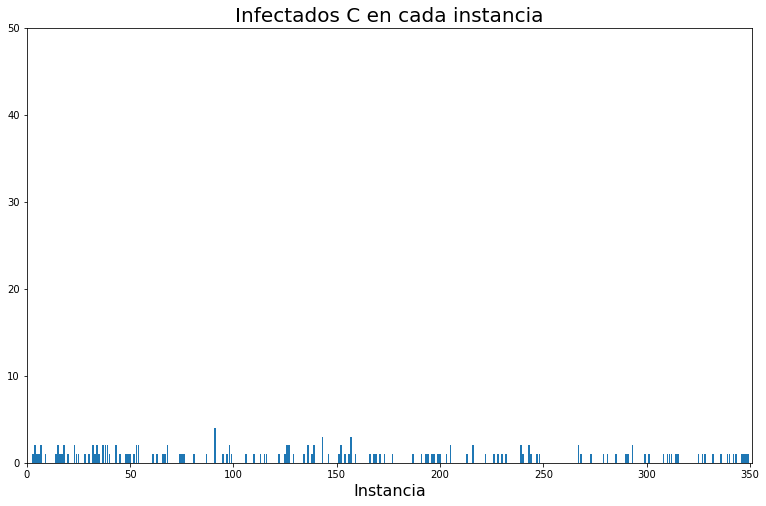

In [71]:

plot3(infection_instanceC,"Infectados C en cada instancia")

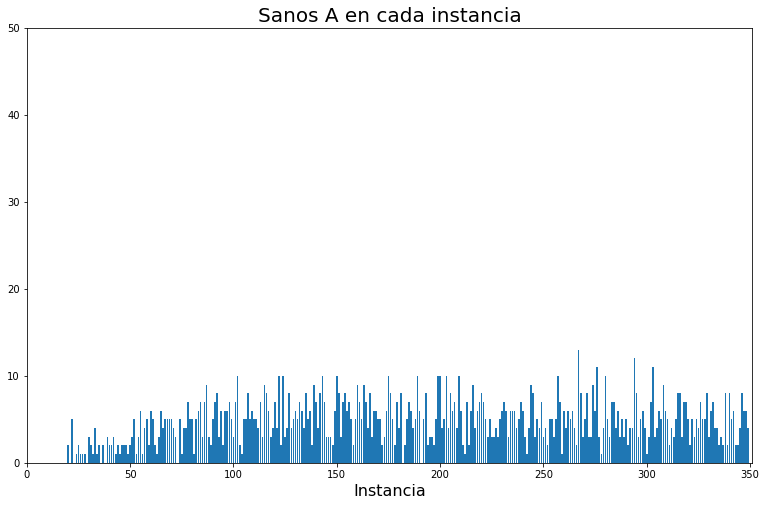

In [72]:

plot3(heal_instanceA,"Sanos A en cada instancia")

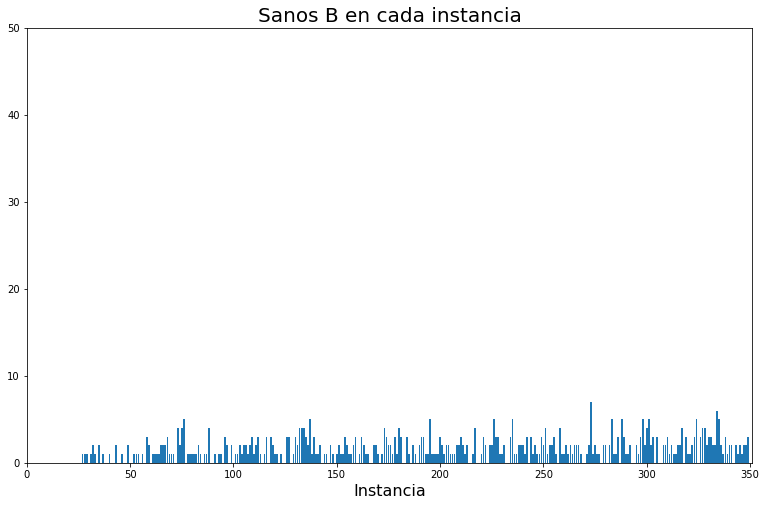

In [73]:

plot3(heal_instanceB,"Sanos B en cada instancia")

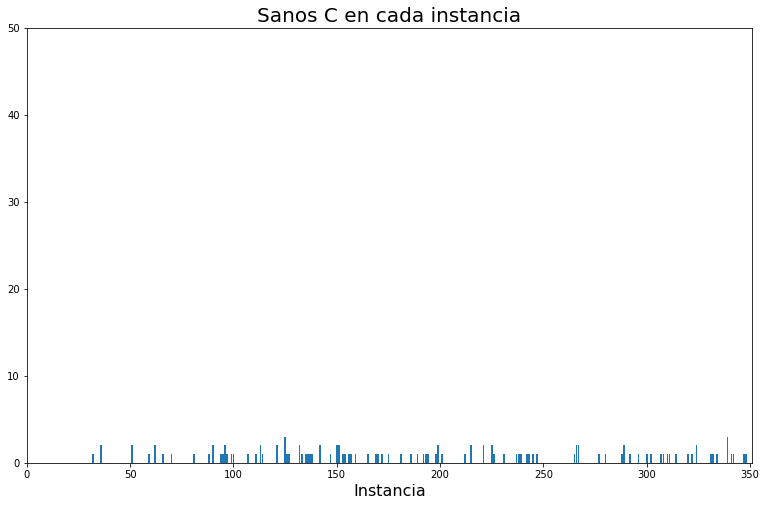

In [74]:

plot3(heal_instanceC,"Sanos C en cada instancia")